In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import xml.etree.ElementTree as ET
import pandas as pd
import random

from tqdm.notebook import tqdm

from src.utils import plot_one_box

cv2.setUseOptimized(True)
cv2.setNumThreads(16)

## Intersection over Union (IoU) function and non-max suppression

In [3]:
def calculate_IoU(bbox1, bbox2):
    """Calculate the Intersection over Union (IoU) of two bounding boxes.

    Args:
        bbox1 (tuple): (x_min, y_min, x_max, y_max) of the first bounding box, (x_min, y_min) is the top left corner of the bounding box, (x_max, y_max) is the bottom right corner of the bounding box (x_min <= x_max, y_min <= y_max)
        bbox2 (tuple): (x_min, y_min, x_max, y_max) of the second bounding box (the same format as bbox1)

    Returns:
        float: IoU of the two bounding boxes
    """
    
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2
    
    x_tl = max(x1_min, x2_min)
    y_tl = max(y1_min, y2_min)
    x_br = min(x1_max, x2_max)
    y_br = min(y1_max, y2_max)
    
    if x_br < x_tl or y_br < y_tl:
        return 0.0

    intersection = max(0, x_br - x_tl) * max(0, y_br - y_tl)

    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - intersection

    return intersection / float(union)

calculate_IoU((2, 2, 4, 4), (2, 2, 5, 5))

0.4444444444444444

In [4]:
def IoU(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Calculate the coordinates of the intersection rectangle
    intersection_rectangle = [max(x1_min, x2_min), max(y1_min, y2_min), min(x1_max, x2_max), min(y1_max, y2_max)]
    
    # Check if there is an intersection
    if intersection_rectangle[2] <= intersection_rectangle[0] or intersection_rectangle[3] <= intersection_rectangle[1]:
        return 0.0
    
    # Calculate the area of the intersection and union
    intersection_area = (intersection_rectangle[2] - intersection_rectangle[0]) * (intersection_rectangle[3] - intersection_rectangle[1])
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - intersection_area
    
    # Return the Intersection over Union
    return intersection_area / union_area

IoU((2, 2, 4, 4), (2, 2, 5, 5))

0.4444444444444444

In [5]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    """Perform non-maximum suppression on the bounding boxes. 
        Reference: https://github.com/PyImageSearch/imutils/blob/master/imutils/object_detection.py

    Args:
        boxes (np.array): bounding boxes in the form (x1, y1, x2, y2)
        probs (np.array, optional): probabilities associated with each bounding box. Defaults to None.
        overlapThresh (float, optional): threshold to determine when boxes overlap too much. Defaults to 0.3.
        
    Returns:
        list: a list of bounding boxes that were selected by non-maximum suppression
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    
    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
        
    # initialize the list of picked indexes
    pick = []
    
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2
    
    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs
        
    # sort the indexes
    idxs = np.argsort(idxs)
    
    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        
        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
        
    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

## Selective search for object detection

In [6]:
def selective_search(image, mode="fast"):
    """Perform selective search on the image

    Args:
        image (np.array): image to perform selective search on (h x w x 3)
        mode (str): "fast" or "quality", "fast" is faster but less accurate (default: "fast")

    Returns:
        rects (list): list of rectangles (x, y, w, h) that were selected by selective search
    """
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    if mode == "quality":
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    return rects

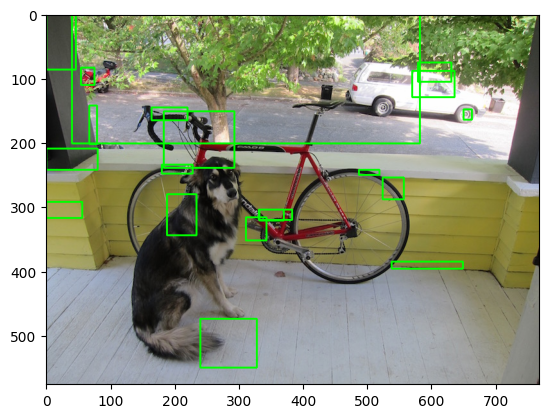

In [7]:
img = cv2.imread("./sample_images/dog_bike_car.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img[50:100, 8:100] = 255 $ first dimension is height (left to right) and second dimension is width (top to bottom)
plt.imshow(img)

rects = selective_search(img, 'fast')
clone = img.copy()
for x, y, w, h in rects[:20]:
    cv2.rectangle(clone, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(clone)
plt.show()

## Region proposal

In [8]:
def region_proposal(img, mode='fast'):
    """Perform region proposal on the image

    Args:
        img (np.array or str): image to perform region proposal on
        mode (str): 'fast' or 'quality' (default: 'fast')

    Returns:
        img (np.array): image that was passed in
        regions (list): list of regions (np.array) that were selected by selective search
        bboxes (list): list of bounding boxes in the form (x, y, w, h)
    """
    if isinstance(img, str):
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    rects = selective_search(img, mode)
    
    regions = []
    bboxes = []
    for x, y, w, h in rects:
        # skip small regions
        if h < height * 0.1 or w < width * 0.1:
            continue
        
        region = img[y:y+h, x:x+w]
        region = cv2.resize(region, (224, 224), interpolation=cv2.INTER_CUBIC)
        regions.append(region)
        bboxes.append((x, y, w, h))
    
    return np.array(img), np.array(regions), bboxes

def plot_regions(img, regions, bboxes):
    # show regions on the image first
    clone = img.copy()
    for x, y, w, h in bboxes[:20]:
        cv2.rectangle(clone, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(clone)
    plt.show()

    fig, ax = plt.subplots(3, 5, figsize=(20, 10))
    for i in range(5):
        ax[0, i].imshow(regions[i])
        ax[1, i].imshow(regions[i+5])
        ax[2, i].imshow(regions[i+10])
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
    plt.tight_layout()
    plt.show()

[INFO] number of regions: 1151


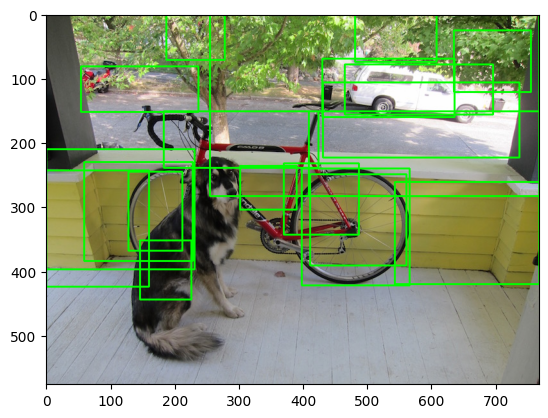

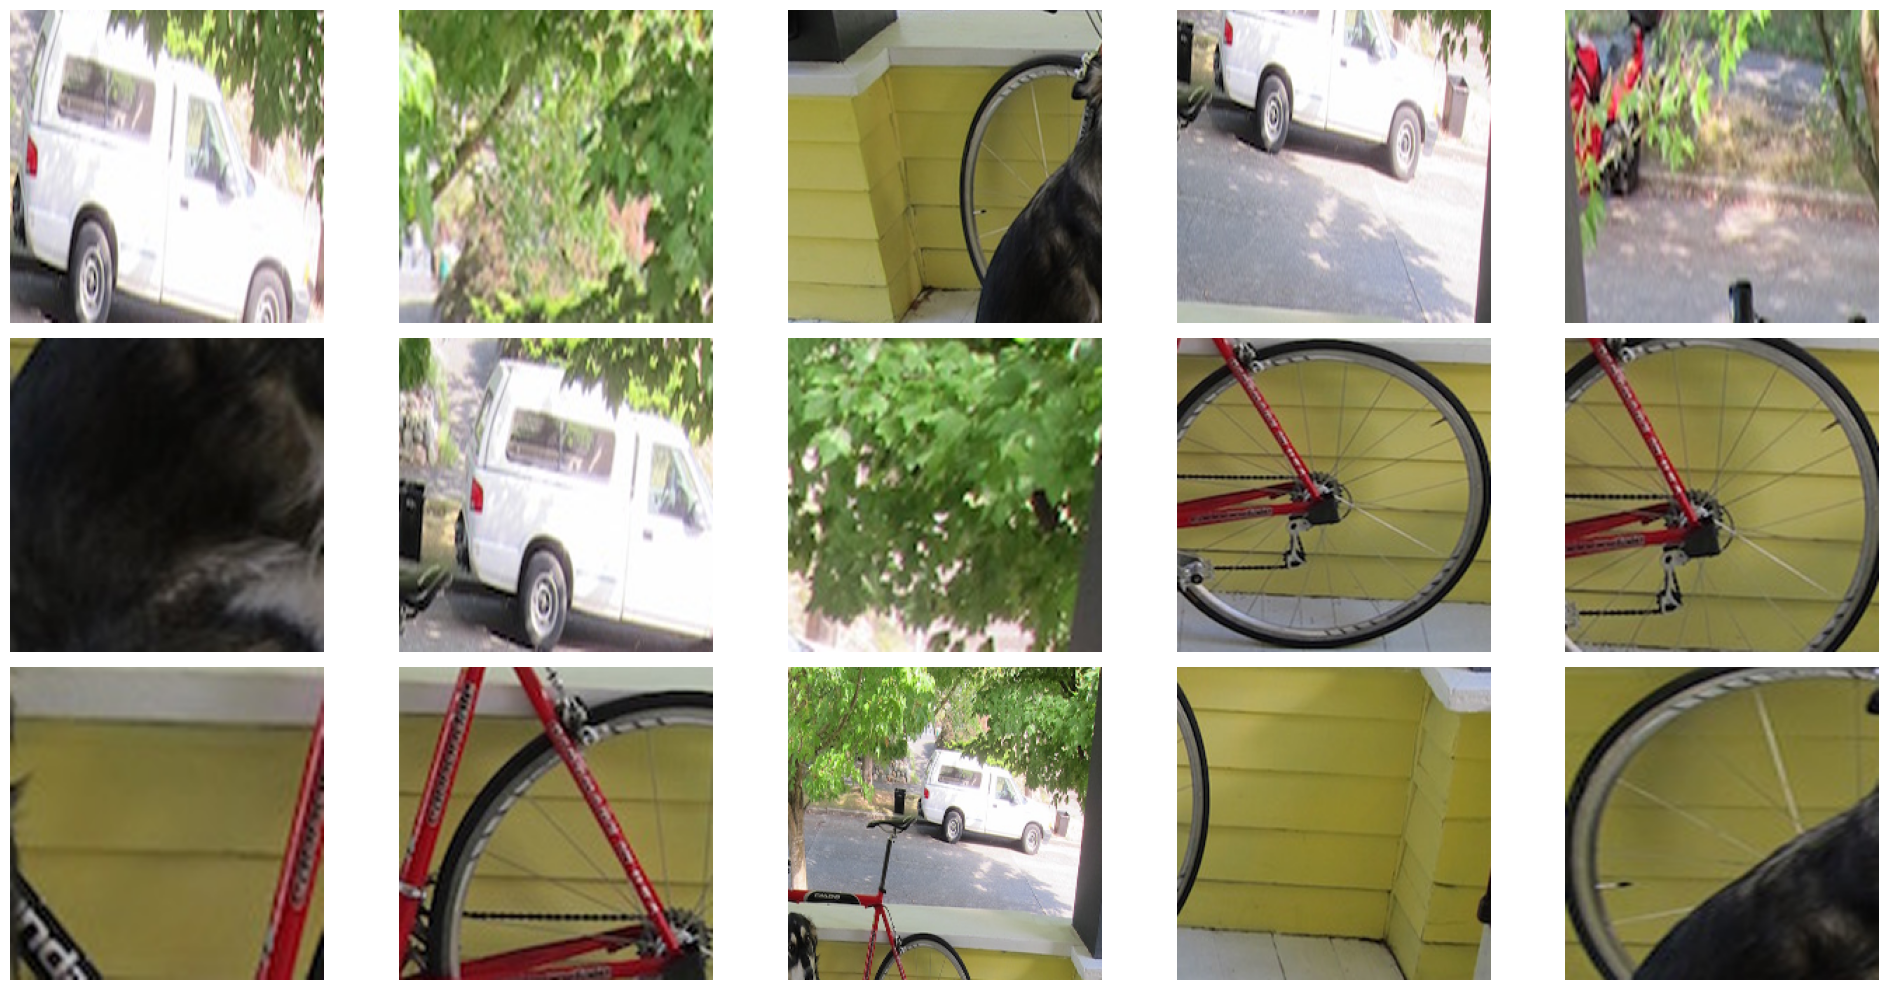

In [9]:
img, regions, bboxes = region_proposal("./sample_images/dog_bike_car.jpg")
print("[INFO] number of regions: {}".format(len(regions)))

plot_regions(img, regions, bboxes)

## Preprocessing

In [10]:
annotation_dir = './dataset/VOC2012/Annotations/'
image_dir = './dataset/VOC2012/JPEGImages/'
region_dir = r'dataset/regions'

classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
print("[INFO] number of classes: {}".format(len(classes)))

[INFO] number of classes: 21


In [11]:
def parse_annotation(xml_path):
    """Parse the xml file and return the image and bounding boxes

    Args:
        xml_path (str): path to the xml file

    Returns:
        bboxes (list): list of bounding boxes in the form (x_min, y_min, x_max, y_max, class_id)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    bboxes = []
    for member in root.findall('object'):
        class_name = member.find('name').text
        if class_name not in classes:
            continue
        class_id = classes.index(class_name)
        bndbox = member.find('bndbox')
        x_min = int(float(bndbox.find('xmin').text))
        y_min = int(float(bndbox.find('ymin').text))
        x_max = int(float(bndbox.find('xmax').text))
        y_max = int(float(bndbox.find('ymax').text))
        bboxes.append([x_min, y_min, x_max, y_max, class_id])
    
    return bboxes

In [12]:
groundtruths = parse_annotation(r'dataset\VOC2012\Annotations\2007_000170.xml')
for *bbox, class_id in groundtruths:
    print(classes[class_id], bbox)

bottle [87, 100, 109, 165]
bottle [41, 114, 73, 181]
bottle [324, 148, 352, 206]
bottle [426, 157, 443, 195]
person [3, 91, 43, 206]
person [4, 28, 461, 372]


In [13]:
MAX_OBJECTS = 10
BG_RATIO = 0.1

df = pd.DataFrame(columns=['image_name', 'class_id', 'x_est', 'y_est', 'w_est', 'h_est', 'x_gt', 'y_gt', 'w_gt', 'h_gt'])

if not os.path.exists(region_dir):
    os.makedirs(region_dir)

dirs = os.listdir(annotation_dir)
random.shuffle(dirs)
dirs = dirs
pbar = tqdm(dirs, desc="Parsing annotations", total=len(dirs), leave=True, position=0)

for annotation_file in pbar:
    try:
        train_images = []
        train_image_names = []
        train_labels = []
        # parse the annotation file to get the bounding boxes and class ids
        gtvalues = parse_annotation(os.path.join(annotation_dir, annotation_file))

        image_name = annotation_file.split(".")[0]+".jpg"
        img, regions, bboxes = region_proposal(os.path.join(image_dir, image_name))
        
        obj_counter = 0
        bg_counter = 0
        is_object = False
        
        for i, (x, y, w, h) in enumerate(bboxes[:2000]):
            region = regions[i]
            est_bbox_xywh = (x, y, w, h)
            
            for i, gtval in enumerate(gtvalues):
                x_gt_min, y_gt_min, x_gt_max, y_gt_max, class_id = gtval
                x_gt, y_gt, w_gt, h_gt = x_gt_min, y_gt_min, x_gt_max-x_gt_min, y_gt_max-y_gt_min
                gt_bbox_xywh = (x_gt, y_gt, w_gt, h_gt)

                iou = calculate_IoU((x_gt_min, y_gt_min, x_gt_max, y_gt_max), (x, y, x+w, y+h))
                is_object = True if iou > 0.7 else False
                
                if is_object and obj_counter < MAX_OBJECTS:
                    
                    train_images.append(region)
                    train_labels.append((class_id, est_bbox_xywh, gt_bbox_xywh))
                    obj_counter += 1
                    
            if is_object == False and (bg_counter < BG_RATIO * MAX_OBJECTS or bg_counter == 0):
                train_images.append(region)
                train_labels.append((0, est_bbox_xywh, gt_bbox_xywh))
                bg_counter += 1
                
            if obj_counter >= MAX_OBJECTS and bg_counter >= BG_RATIO * MAX_OBJECTS:
                break
        
        for j, (img, label) in enumerate(zip(train_images, train_labels)):
            class_id, est_bbox_xywh, gt_bbox_xywh = label
            x_est, y_est, w_est, h_est = est_bbox_xywh
            x_gt, y_gt, w_gt, h_gt = gt_bbox_xywh
            
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img_name = f'{image_name.split(".")[0]}_{j}.jpg'
            cv2.imwrite(os.path.join(region_dir, img_name), img)
            tmp = {
                'image_name': img_name, 
                'class_id': class_id, 
                'x_est': x_est, 'y_est': y_est, 'w_est': w_est, 'h_est': h_est, 
                'x_gt': x_gt, 'y_gt': y_gt, 'w_gt': w_gt, 'h_gt': h_gt
                }
            df.loc[len(df)] = tmp
            
    except Exception as e:
        print(e)
        print(f'Error in {annotation_file}')
        # continue
        continue

df.to_csv('dataset/regions.csv', index=False)

Parsing annotations:   0%|          | 0/17125 [00:00<?, ?it/s]

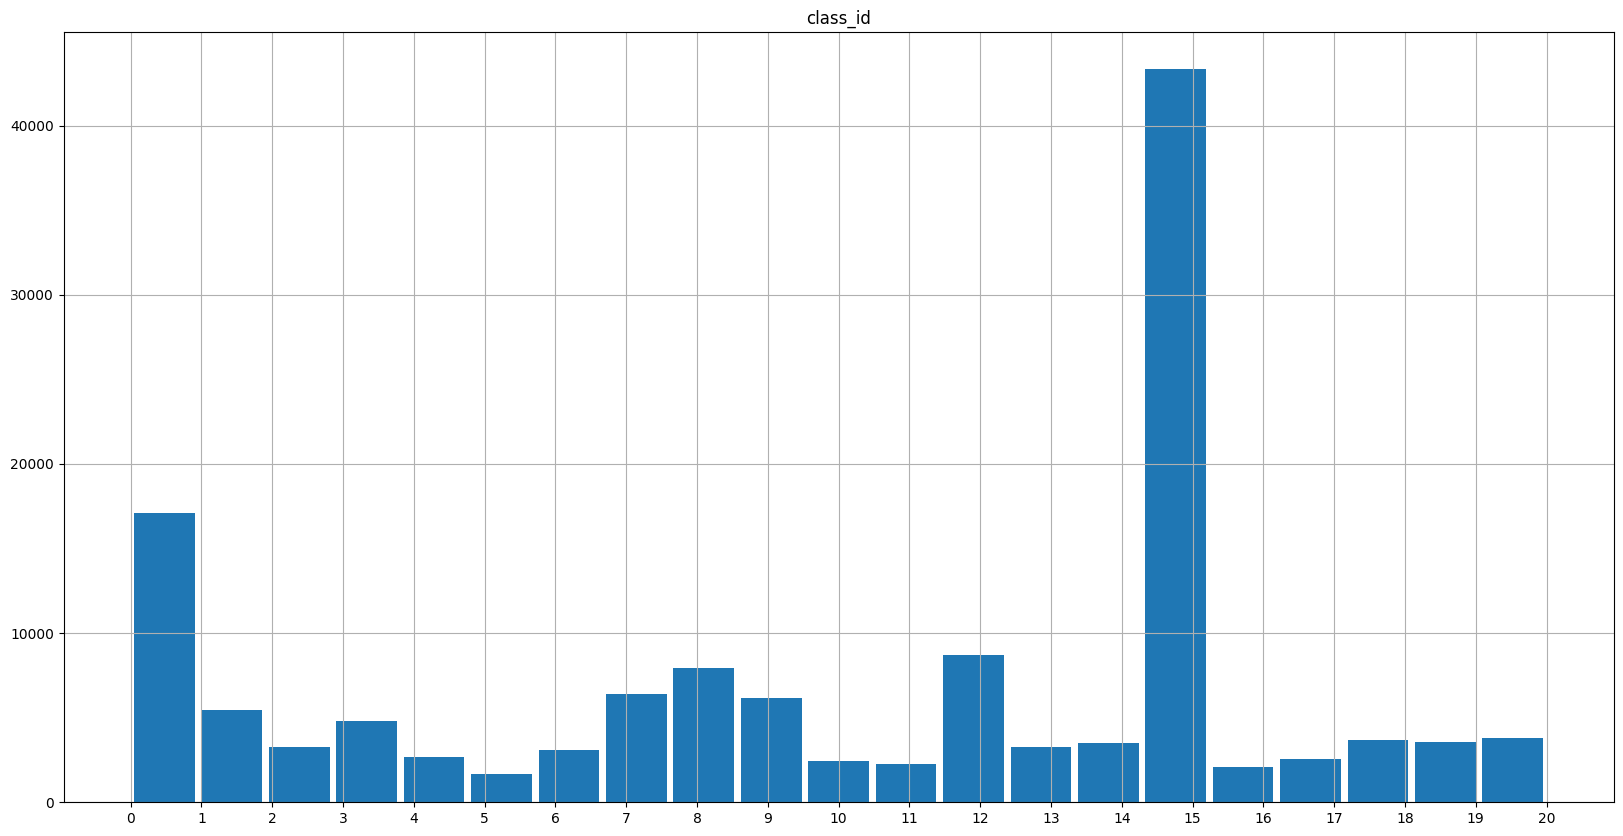

In [33]:
# plt.figure(figsize=(20, 10))
# plt.hist(df['class_id'], bins=21)
# plt.xticks(range(21))
# plt.show()

df.hist(column='class_id', bins=21, figsize=(20, 10), rwidth=0.9)
plt.xticks(range(21))
plt.show()

In [14]:
# print("[INFO] number of training images: {}".format(len(train_images)))
# print("[INFO] number of training labels: {}".format(len(train_labels)))
# print("[INFO] number of objects: {}".format(sum([1 for label in train_labels if label[0] != 0])))
# print("[INFO] number of background: {}".format(sum([1 for label in train_labels if label[0] == 0])))

# fig, ax = plt.subplots(3, 5, figsize=(20, 10))
# cnt = 0
# cnt_bg = 0
# for region, (class_id, est_bbox_xywh, gt_bbox_xywh) in zip(train_images, train_labels):
#     if class_id != 0 or (class_id == 0 and cnt_bg < 5):
#         ax[cnt//5, cnt%5].imshow(region)
#         ax[cnt//5, cnt%5].axis('off')
#         # add the ground truth bounding box as text
#         ax[cnt//5, cnt%5].text(0, -36, classes[class_id], color='green' if class_id != 0 else 'red', fontsize=10)
#         ax[cnt//5, cnt%5].text(0, -24, f'est bbox: {str(est_bbox_xywh)}', color='blue', fontsize=10)
#         ax[cnt//5, cnt%5].text(0, -12, f'gt bbox: {str(gt_bbox_xywh)}', color='blue', fontsize=10)
#         cnt += 1
#     if cnt == 15:
#         break
# plt.show()

## Model

In [15]:
# https://pytorch.org/vision/stable/models.html

weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1
model = torchvision.models.vgg16(weights=weights)
model.eval()
transforms = weights.transforms()
print(transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### Test pretrained VGG from torchvision

In [ ]:
weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1
model = torchvision.models.vgg16(weights=weights)
# weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
# model = torchvision.models.resnet50(weights=weights)
model.eval()
transforms = weights.transforms()
print(transforms)

In [ ]:
img = cv2.imread('./sample_images/apple.jpg')
img = torch.FloatTensor(img).permute(2, 0, 1)
input = transforms(img).unsqueeze(0)
print(f'input.shape: {input.shape}')

feature_extractor = model.features
features = feature_extractor(input)
print(f'features.shape: {features.shape}')

flatten = torch.nn.AdaptiveAvgPool2d(1)
flatten_features = flatten(features)
print(f'flatten_features.shape: {flatten_features.shape}')

output = model(input)
print(f'output.shape: {output.shape}')

### RCNN Model

In [16]:
from collections import OrderedDict

class RCNN(nn.Module):
    def __init__(self, backbone, classes):
        super().__init__()
        self.backbone = backbone
        self.backbone.requires_grad_(False)

        self.classifier = nn.Sequential(OrderedDict([
            ('dropout', nn.Dropout(0.2)),
            ('classifier_fc', nn.Linear(25088, len(classes)))
        ]))
        
        self.rpn = nn.Sequential(OrderedDict([
            ('dropout', nn.Dropout(0.2)),
            ('rpn_fc', nn.Linear(25088, 4))
        ]))
        
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.idx_to_class = {i: c for i, c in enumerate(classes)}
        
    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
            features = features.flatten(start_dim=1)
            
        class_id = self.classifier(features)
        box = self.rpn(features)
        
        return class_id, box
    
    def save(self, path):
        # save classifier and rpn only
        save_dict = {
            'classifier': self.classifier.state_dict(),
            'rpn': self.rpn.state_dict(),
            'classes': self.classes,
            'class_to_idx': self.class_to_idx,
            'idx_to_class': self.idx_to_class
        }
        torch.save(save_dict, path)

    def load(self, path):
        # load classifier and rpn only
        checkpoint = torch.load(path)
        self.classifier.load_state_dict(checkpoint['classifier'])
        self.rpn.load_state_dict(checkpoint['rpn'])
        self.classes = checkpoint['classes']
        self.class_to_idx = checkpoint['class_to_idx']
        self.idx_to_class = checkpoint['idx_to_class']

## Training and fine-tuning RPN function

In [17]:
def training(model, train_loader, train_config, device):
    clf_criterion = nn.CrossEntropyLoss()
    box_criterion = nn.MSELoss()
    
    # Optimizer for classification and regression
    optimizer = optim.Adam(
        model.classifier.parameters() if not train_config.get('bbox_reg', False) else model.parameters(),
        lr=train_config.get('learning_rate', 0.001),
        weight_decay=train_config.get('weight_decay', 0.0005)
    )
    
    for epoch in range(train_config.get('epochs', 1)):
        model.train()  # set model to train mode
        print(f'Epoch {epoch + 1}/{train_config["epochs"]}')
        clf_losses = []
        box_losses = []
        pbar = tqdm(train_loader, position=0, leave=True, total=len(train_loader))
        
        for step, data in enumerate(pbar):
            data = {k: v.to(device) for k, v in data.items()}
            labels = data['class_id'].squeeze().long()
            
            optimizer.zero_grad()
            preds, bbox = model(data['image'])
            
            clf_loss = clf_criterion(preds, labels)
            loss = clf_loss
            clf_losses.append(clf_loss.item())
            
            # bbox reg
            if train_config.get('bbox_reg', False):
                p_x, p_y, p_w, p_h = data['est_bbox'].to(device).split(1, dim=1)
                g_x, g_y, g_w, g_h = data['gt_bbox'].to(device).split(1, dim=1)
                
                bbox_ans = torch.cat([(g_x - p_x) / p_w, (g_y - p_y) / p_h, torch.log(g_w / p_w), torch.log(g_h / p_h)], dim=1)
                bbox_ans = bbox_ans.float().to(device)
                
                mask = (data['class_id'] != 0).reshape(len(data['class_id']), 1).float().to(device)
                bbox = bbox * mask
                bbox_ans = bbox_ans * mask
                
                bbox_loss = box_criterion(bbox, bbox_ans)
                loss += bbox_loss
                box_losses.append(bbox_loss.item())
                pbar.set_description(f"Cls Loss: {clf_loss.item():.4f} | Bbox Loss: {bbox_loss.item():.4f}")
            else:
                pbar.set_description(f"Cls Loss: {clf_loss.item():.4f}")
            pbar.update()
            
            loss.backward()
            optimizer.step()
        
        print(f'Avg Cls Loss: {np.mean(clf_losses):.4f}')
        if train_config.get('bbox_reg', False):
            print(f'Avg Bbox Loss: {np.mean(box_losses):.4f}')
        print('#' * 50, end='\n\n')

## Dataset and data loader

In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_path, transform=None):
        self.image_dir = image_dir
        self.data = pd.read_csv(label_path)
        
        if transform is None:
            transform = transforms.Compose([
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                ),
                transforms.Resize((224, 224))
            ])
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        
        img_path = os.path.join(self.image_dir, data[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.FloatTensor(img).permute(2, 0, 1) / 255
        
        class_id = data[1]
        
        x_est, y_est, w_est, h_est = data[2:6]
        x_gt, y_gt, w_gt, h_gt = data[6:]
        
        if self.transform:
            img = self.transform(img)
            
        return {
            'image': img,
            'class_id': torch.LongTensor([class_id]),
            'est_bbox': torch.FloatTensor([x_est, y_est, w_est, h_est]),
            'gt_bbox': torch.FloatTensor([x_gt, y_gt, w_gt, h_gt])
        }

## Training

In [19]:
dataset = Dataset(region_dir, 'dataset/regions.csv', transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [20]:
weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1
backbone = torchvision.models.vgg16(weights=weights)
# weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
# model = torchvision.models.resnet50(weights=weights)
model.eval()
transforms = weights.transforms()

model = RCNN(backbone.features, classes)

In [21]:
train_classifier_config = {
    'epochs': 2,
    'learning_rate': 1e-3,
    'bbox_reg': False,
    'weight_decay': 0.001
}

fine_tuning_config = {
    'epochs': 1,
    'learning_rate': 1e-3,
    'bbox_reg': True,
    'weight_decay': 0.001
}

fine_tuning_config2 = {
    'epochs': 2,
    'learning_rate': 1e-4,
    'bbox_reg': True,
    'weight_decay': 0.001
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
training(model, dataloader, train_classifier_config, device)

In [ ]:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
training(model, dataloader, fine_tuning_config2, device)

## Inference

In [ ]:
def refine_bbox(bbox, delta):
    x, y, w, h = bbox
    dx, dy, dw, dh = delta
    
    x = x + dx * w
    y = y + dy * h
    w = w * torch.exp(dw)
    h = h * torch.exp(dh)
    
    return torch.stack([x, y, w, h])

def detect(model, img, transform, classes, device, threshold=0.8):
    model.eval()
    img, regions, bboxes = region_proposal(img)
    print(f'[INFO] Found {len(regions)} regions')
    
    dataloader = torch.utils.data.DataLoader(np.array(regions, dtype=np.float32), batch_size=32, shuffle=False)
    pbar = tqdm(dataloader, total=len(dataloader))
    for batch_idx, batch in enumerate(pbar):
        regions = transform(torch.FloatTensor(batch).permute(0, 3, 1, 2) / 255).to(device)
        
        score, bbox = model(regions)
        score = score.softmax(axis=1).cpu().detach().numpy()
        bbox = bbox.cpu().detach()
        
        pred = np.argmax(score, axis=1)
        # print(f'pred: {pred}')
        # print(f'score:', end=' ')
        # for i in range(len(pred)):
        #     print(f'{score[i][pred[i]]:.2f}', end=' ')
        # print(f'pred.shape: {pred.shape}')
        # print(f'score.shape: {score.shape}')
        print(f'bbox.shape: {bbox.shape}')
        # print(score)
        
        pred = pred.tolist()
        for j in range(len(pred)):
            if pred[j] != 0 and score[j][pred[j]] > threshold:
                print(f'[INFO] Detected {classes[pred[j]]} with confidence {score[j][pred[j]]:.2f}')
                region_bbox = bboxes[batch_idx * 32 + j]
                delta = bbox[j]
                refined_bbox = refine_bbox(region_bbox, delta)
                
                clone = img.copy()
                x, y, w, h = refined_bbox.numpy()
                x, y, w, h = np.clip(x, 0, img.shape[1]), np.clip(y, 0, img.shape[0]), np.clip(w, 0, img.shape[1]), np.clip(h, 0, img.shape[0])
                x, y, w, h = int(x), int(y), int(w), int(h)
                # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv2.putText(img, classes[pred[i]], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                # plt.imshow(img)
                # plt.show()
                plot_one_box((x, y, x + w, y + h), clone, label=f'{classes[pred[j]]} {score[j][pred[j]]:.2f}')
                plt.imshow(clone)
                plt.show()

In [ ]:
detect(model, "./sample_images/apples2.jpg", transforms, classes, device, threshold=0.5)

In [ ]:
# def visualize(model, dataset, device, idx):
#     model.eval()
#     data = dataset[idx]
#     data = {k: v.to(device) for k, v in data.items()}
#     img = data['image'].permute(1, 2, 0).cpu().numpy()
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     img = img * 255
#     img = img.astype(np.uint8)
    
#     pred, bbox = model(data['image'].unsqueeze(0))
#     pred = pred.squeeze().cpu().detach().numpy()
#     bbox = bbox.squeeze().cpu().detach().numpy()
    
#     pred = np.argmax(pred)
#     bbox = refine_bbox(data['est_bbox'], bbox)
#     x, y, w, h = bbox
#     x, y, w, h = int(x), int(y), int(w), int(h)
    
#     img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
#     img = cv2.putText(img, str(pred), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     plt.imshow(img)
#     plt.show()

In [ ]:
a = np.array([[1, 2, 3], [4, 8, 6]])
np.argmax(a, axis=1)

In [ ]:
test_img = cv2.imread("./sample_images/apple.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (224, 224))
test_img = torch.FloatTensor(test_img).permute(2, 0, 1) / 255
test_img = test_img.unsqueeze(0)
with torch.no_grad():
    test_img_pred, test_img_bbox = model(test_img.to(device))
    test_img_pred = test_img_pred.softmax(axis=1).cpu().detach().numpy().squeeze()
    
print(f'Predicted class: {classes[np.argmax(test_img_pred)]} with confidence {np.max(test_img_pred):.2f}')

test_img = cv2.cvtColor(test_img.squeeze().permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR)
cv2.imwrite("test_img.jpg", test_img * 255)

In [ ]:
for i, c in enumerate(classes):
    print(f'{i}: {c}')